In [1]:
using FileIO, DelimitedFiles, HDF5
using Plots, Rsvg, LaTeXStrings
using LinearAlgebra, Statistics
using JUMD, Chemfiles
home = "/home/pbarletta/labo/18/lbp/run"
rtdos = "/home/pbarletta/labo/18/lbp/rtdos_log"
pyplot()

Plots.PlotlyBackend()

### Lee modos, volumen original y  volúmenes NDD. Obtiene VGV

In [2]:
pdb = "2w9y"
# Leo modos
modes_2w9y, evals_2w9y = JUMD.read_ptraj_modes(
    joinpath(home, pdb,  "pca", string("full_modes_", pdb)))
# AAs
aa3 = convert(Int64, length(evals_2w9y))
aa = convert(Int64, aa3 / 3)

# Leo volumen de la traj
trj_vol = convert(Array{Float64, 1}, 
    readdlm(joinpath(home, pdb, "cavidad", string("vol_trj_", pdb)))[:, 3]);

# Leo volúmenes originales
vol_avg_2w9y = convert(Float64, readdlm(joinpath(home, pdb,  "ndd", string("vol_avg_", pdb)))[3])

# Leo volúmenes NDD
ndd_out_2w9y = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb,  "ndd", string("out_ndd_", pdb)))[2:end, 2])

# VGV
vgv_2w9y = (ndd_out_2w9y .- vol_avg_2w9y) .* evals_2w9y
vgv_2w9y = vgv_2w9y ./ norm(vgv_2w9y);

### Obtiene los aa's del hueco

In [3]:
# VGV cartesiano
xyz_vgv_2w9y = JUMD.tognm(modes_2w9y * vgv_2w9y)

# Pnumber aminoácidos según VGV (aminoácidos de la pared)
cut_2w9y = JUMD.get_pnum(xyz_vgv_2w9y)

# Índices de pnumber aminoácidos
idx_cut_2w9y = sort(sortperm(abs.(xyz_vgv_2w9y), rev = true)[1:cut_2w9y])

# Índices de pnumber aminoácidos en 3aa coordenadas
idx_cut_2w9y_3 = Array{Int64}(undef, length(idx_cut_2w9y) * 3)
for i = 1:length(idx_cut_2w9y)
    idx_cut_2w9y_3[3*i-2] = idx_cut_2w9y[i] * 3 - 2
    idx_cut_2w9y_3[3*i-1] = idx_cut_2w9y[i] * 3 - 1
    idx_cut_2w9y_3[3*i] = idx_cut_2w9y[i] * 3
end

### Obtiene los pnum modos y pnum eigenvals. Cut y enteros

In [4]:
# Pnumber de VGV
vgv_pnu_2w9y = JUMD.get_pnum(vgv_2w9y)

# Pnumber indices
idx_vgv_pnu_2w9y = sortperm(abs.(vgv_2w9y), rev=true)[1:vgv_pnu_2w9y]

# Pnumber modes
modes_pnu_2w9y = modes_2w9y[:, idx_vgv_pnu_2w9y]

# Pnumber eigenvalues
evals_pnu_2w9y = evals_2w9y[idx_vgv_pnu_2w9y];

# Todos los modos recortados según pnumber aminoácidos y normalizo
modes_cut_2w9y = modes_2w9y[idx_cut_2w9y_3, :]
modes_cut_2w9y = mapslices(x -> x ./ norm(x), modes_cut_2w9y, dims = 1)

# Pnum modos recortados según pnumber aminoácidos y normalizo
modes_pnu_cut_2w9y = modes_pnu_2w9y[idx_cut_2w9y_3, :]
modes_pnu_cut_2w9y = mapslices(x -> x ./ norm(x), modes_pnu_cut_2w9y, dims = 1);

### κ

In [5]:
# Colectividad de modos enteros
tmp = eval(:(mapslices(x -> JUMD.get_κ(x), mapslices(x -> JUMD.tognm(x), modes_2w9y, dims = 1), dims = 1)))
κ_modes_2w9y = reshape(tmp, length(tmp))

# Colectividad de pnum modos enteros
tmp = eval(:(mapslices(x -> JUMD.get_κ(x), mapslices(x -> JUMD.tognm(x), modes_pnu_2w9y, dims = 1), dims = 1)))
κ_modes_pnu_2w9y  = reshape(tmp, length(tmp))

# Colectividad de modos recortados
tmp = mapslices(x -> JUMD.get_κ(x), mapslices(x -> JUMD.tognm(x), modes_cut_2w9y, dims = 1),dims =  1)
κ_modes_cut_2w9y  = reshape(tmp, length(tmp))

# Colectividad de pnum modos recortados
tmp = mapslices(x -> JUMD.get_κ(x), mapslices(x -> JUMD.tognm(x), modes_pnu_cut_2w9y, dims = 1), dims = 1)
κ_modes_pnu_cut_2w9y = reshape(tmp, length(tmp));

### Pnumber

In [6]:
# Pnumber de modos enteros
tmp = mapslices(x -> JUMD.get_pnum(x),
    mapslices(x -> JUMD.tognm(x), modes_2w9y, dims = 1), dims = 1)
col_modes_2w9y = reshape(tmp, length(tmp)) ./ aa

# Pnumber de pnum modos enteros
tmp = mapslices(x -> JUMD.get_pnum(x),
    mapslices(x -> JUMD.tognm(x), modes_pnu_2w9y, dims = 1), dims = 1)
col_modes_pnu_2w9y = reshape(tmp, length(tmp)) ./ aa

# Pnumber de modos cut
tmp = mapslices(x -> JUMD.get_pnum(x),
    mapslices(x -> JUMD.tognm(x), modes_cut_2w9y, dims = 1), dims = 1)
col_modes_cut_2w9y = reshape(tmp, length(tmp))  ./ cut_2w9y

# Pnumber de pnum modos cut
tmp = mapslices(x -> JUMD.get_pnum(x),
    mapslices(x -> JUMD.tognm(x), modes_pnu_cut_2w9y, dims = 1), dims = 1)
col_modes_pnu_cut_2w9y = reshape(tmp, length(tmp))  ./ cut_2w9y;

### Frecuencia

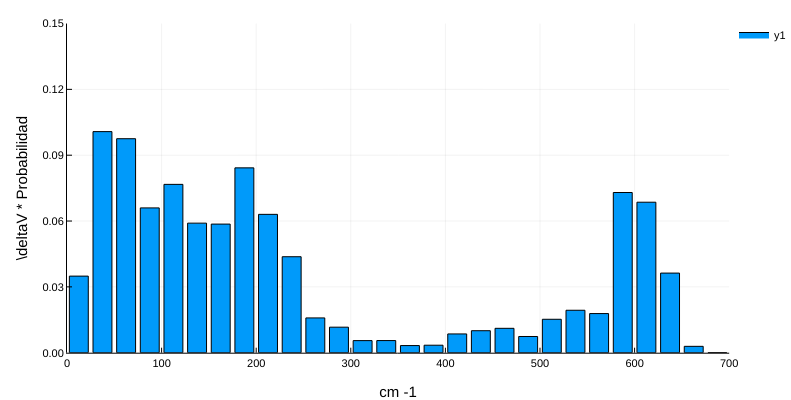

In [7]:
# Los bins van de 0 a la fqcia más alta + 10%
top_evals = maximum(evals_2w9y)
bins_evals = collect(0:25:700)

# Histograma ponderado
Wbins_evals_2w9y, Whis_evals_2w9y = JUMD.WeightedHist(evals_2w9y, bins_evals, abs.(vgv_2w9y),
    true, false);

bar(Wbins_evals_2w9y, Whis_evals_2w9y,
    xlims = (0, 700), ylims = (0, .15),
    yaxis = "\\deltaV * Probabilidad", xaxis = "cm -1")

### Colectividad

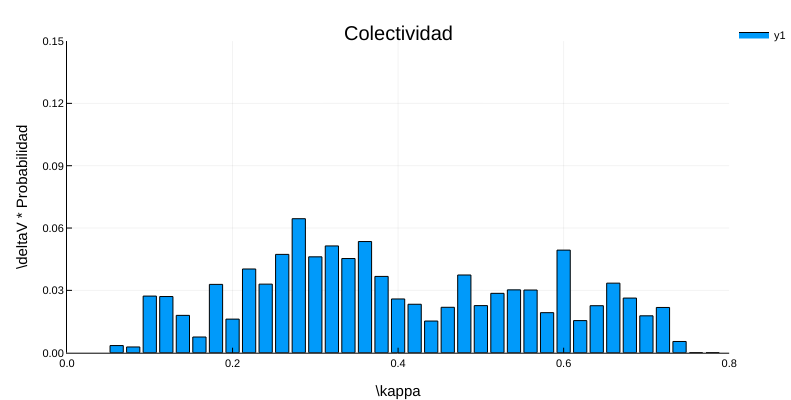

In [8]:
# Los bins van de 0 a la fqcia más alta + 10%
top_κ = maximum(κ_modes_2w9y)
bins_κ = collect(0.05:.02:.8)

# Histograma ponderado
Wbins_κ_2w9y, Whis_κ_2w9y = JUMD.WeightedHist(κ_modes_2w9y, bins_κ, abs.(vgv_2w9y),
    true, false);

bar(Wbins_κ_2w9y, Whis_κ_2w9y,
    title = "Colectividad",
    xlims = (0, .8), ylims = (0, .15),
    yaxis = "\\deltaV * Probabilidad", xaxis = "\\kappa")


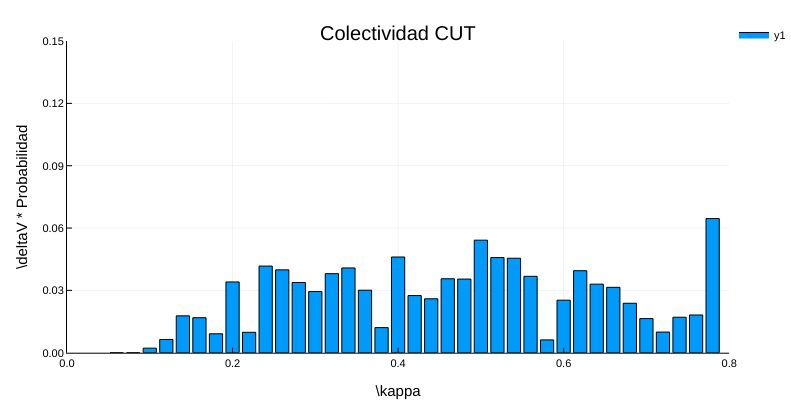

In [9]:
Wbins_κ_cut_2w9y, Whis_κ_cut_2w9y = JUMD.WeightedHist(κ_modes_cut_2w9y, bins_κ, abs.(vgv_2w9y), true);

bar(Wbins_κ_cut_2w9y, Whis_κ_cut_2w9y,
    title = "Colectividad CUT",
    xlims = (0, .8), ylims = (0, .15),
    yaxis = "\\deltaV * Probabilidad", xaxis = "\\kappa")

### Colectividad en pnumber

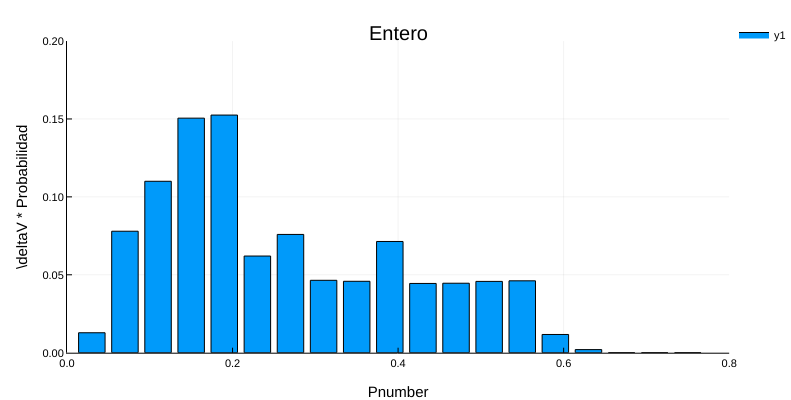

In [10]:
# Los bins van de 0 a la fqcia más alta + 10%
top_col = maximum(col_modes_2w9y)
bins_col = collect(0.01:.04:.8)

# Histograma ponderado
Wbins_col_2w9y, Whis_col_2w9y = JUMD.WeightedHist(col_modes_2w9y, bins_col, abs.(vgv_2w9y),
    true, false);

bar(Wbins_col_2w9y, Whis_col_2w9y,
    xlims = (0., .8), ylims = (0, .2),
    yaxis = "\\deltaV * Probabilidad", xaxis = "Pnumber", title = "Entero")

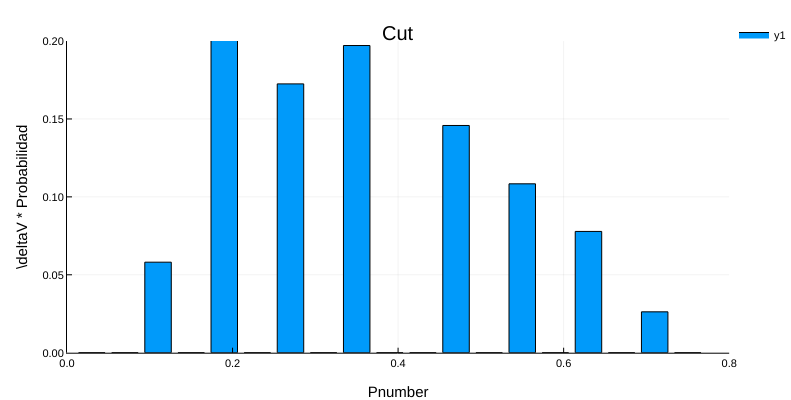

In [11]:
# Uso los bins de arriba
# Histograma ponderado
Wbins_col_cut_2w9y, Whis_col_cut_2w9y = JUMD.WeightedHist(col_modes_cut_2w9y, bins_col, abs.(vgv_2w9y),
    true, false);

bar(Wbins_col_cut_2w9y, Whis_col_cut_2w9y,
    xlims = (0., .8), ylims = (0, .2),
    yaxis = "\\deltaV * Probabilidad", xaxis = "Pnumber", title = "Cut")

## AAs de la pared

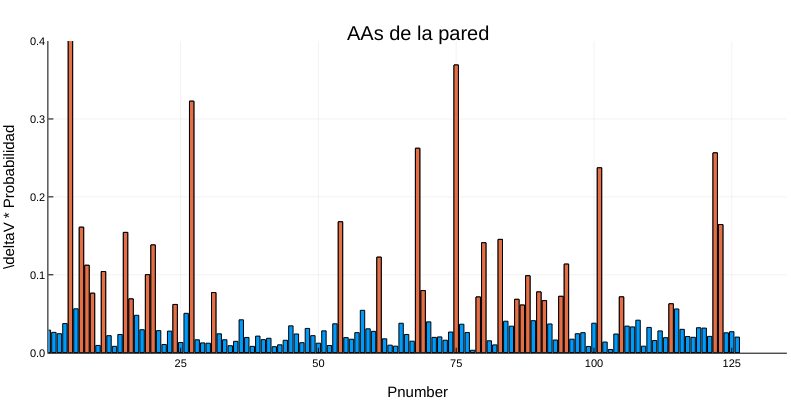

In [12]:
tmp = abs.(xyz_vgv_2w9y)
tmp_ = copy(tmp)
tmp_[tmp_ .< .06] .= 0.;

bar(tmp,
    xlims = (1, 135), ylims = (0, .4),
    yaxis = "\\deltaV * Probabilidad", xaxis = "Pnumber", title = "AAs de la pared",
    legend = false, size = (750, 400))
bar!(tmp_)

## Volumen de la trayectoria

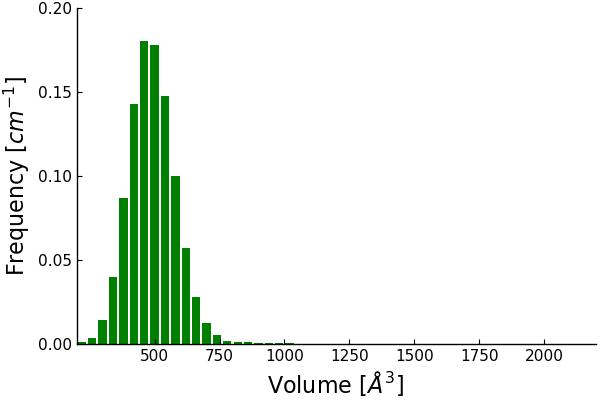

In [61]:
st = 40
bin_vol = collect(200:st:1200)
wgh_vol = fill(1.0, length(trj_vol))

# Histograma ponderado
Wbins_vol_2w9y, Whis_vol_2w9y = JUMD.WeightedHist(trj_vol, bin_vol, wgh_vol, true, false);

plt_his_vol = bar(Wbins_vol_2w9y, Whis_vol_2w9y,
    xlims = (200, 2200), ylims = (0, .2),
    xticks = 500:250:2000,
    grid = false, guidefont = font(16, "cursive"), tickfont = font(11, "cursive"),
    yaxis = L"Frequency $[cm^{-1}]$", xaxis = L"Volume $[\AA^3]$ ",
    linecolor = false, fillcolor = Colors.colorant"#008000",
    legend = false)

In [62]:
savefig(plt_his_vol, joinpath(rtdos, "papel", "1", string("1_vol_", pdb, ".svg")))

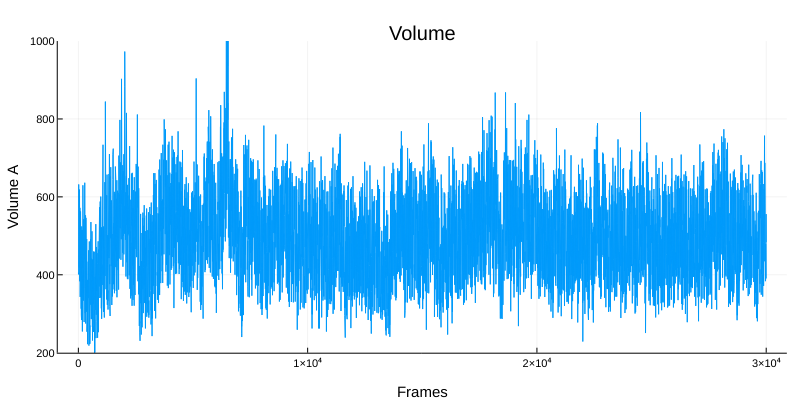

In [14]:
plot(trj_vol,
    yaxis = "Volume A", xaxis = "Frames", title = "Volume",
    ylims = (200, 1000),
    legend = false, size = (750, 400))

In [18]:
[ mean(trj_vol) ; std(trj_vol) ]

2-element Array{Float64,1}:
 491.29946563333334
  88.4187380575453 

## Energía

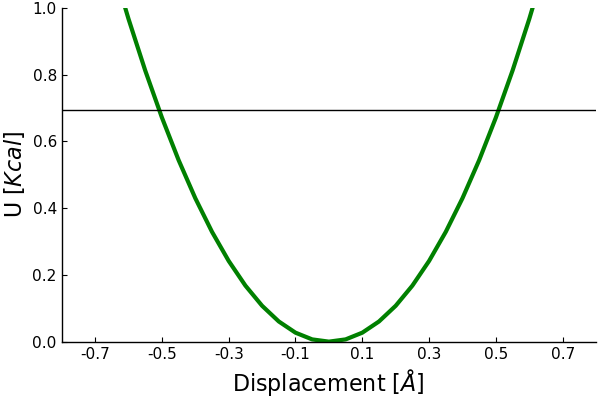

In [59]:
pasos = collect(-.8:.05:.8)
npasos = length(pasos)
RT = 0.693

E_2w9y = Array{Float64,1}(undef, npasos)
i = 0
for d in pasos
    i+=1
    E_2w9y[i] = JUMD.energia_gdte(evals_2w9y, vgv_2w9y, d)
end

plt_u = plot(pasos, E_2w9y,
    xticks = -.7:.2:.7, yticks = 0:.2:1.,   
    xlims = (-.8, .8), ylims = (0, 1.),
    grid = false, guidefont = font(16, "Helvetica"), tickfont = font(11, "Helvetica"),
    yaxis = L"U $[Kcal]$", xaxis = L"Displacement $[\AA]$ ",
    linecolor = Colors.colorant"#008000", linewidth = 3,
    legend = false)

hline!([RT], linecolor = Colors.colorant"black")

In [60]:
savefig(plt_u, joinpath(rtdos, "papel", "7", string("7_U_", pdb, ".svg")))

# PCA projección
#### Obtengo vectores diferencia de la trayectoria. Esto lo hago una sola vez

function diff_trj_avg(in_avg_filename::AbstractString, in_trj_filename::AbstractString,
        mask::Array{Int64, 1})
    in_avg_trj = Trajectory(in_avg_filename)
    in_avg_frm = read(in_avg_trj)
    in_avg_top = Topology(in_avg_frm)
    orig_aa = convert(Int64, count_residues(in_avg_top))

    # Get indices de CA
    orig_cas_idx = Array{Int64, 1}(undef, orig_aa)
    k = 0
    for i = 0:convert(Int64, size(in_avg_top)-1)
        if Chemfiles.name(Atom(in_avg_frm, i)) == "CA"
            k+=1
            orig_cas_idx[k] = i + 1
        end
    end
    cas_idx = orig_cas_idx[mask]
    aa = length(cas_idx)
    aa_3 = aa * 3
    # Estas son las coordenadas q voy a usar p/ restar
    avg_xyz = positions(in_avg_frm)[:, cas_idx];

    # Preparo
    in_trj = Trajectory(in_trj_filename)
    nframes = convert(Int64, nsteps(in_trj))
    close(in_trj)
    diff_pdb = Array{Float64, 2}(aa_3, nframes)
    vec_nframes = convert(Array{Int64}, collect(0:nframes/10:nframes));

    # Ahora obtengo las proyecciones
    for j = 1:length(vec_nframes)-1
        in_trj = Trajectory(in_trj_filename)
        for i = vec_nframes[j]:vec_nframes[j+1]-1
            diff_pdb[:, i+1] =
                reshape(positions(read_step(in_trj, i))[:, cas_idx] .- avg_xyz, aa_3)
        end
        close(in_trj)
        println(j)
        GC.gc()
    end

    return diff_pdb
end

dif = diff_trj_avg(joinpath(home, pdb, "pca", string("full_avg_", pdb, ".pdb")),
    joinpath(home, pdb, "pca", string("full_avgfit_", pdb, ".nc")),
    collect(7:132))

fid = h5open(joinpath(rtdos, string("diff_", pdb, ".h5")), "w")
write(fid, "dif",dif)
close(fid)

### Obtengo proyecciones de PCA sobre trayectoria

In [20]:
dif = h5read(joinpath(rtdos, string("diff_", pdb, ".h5")), "dif")
norm_dif = mapslices(x -> x ./ norm(x), dif,  dims = 1)
nframes = size(dif)[2]

prj_1_2w9y = Array{Float64, 1}(undef, nframes)
prj_2_2w9y = Array{Float64, 1}(undef, nframes)
prj_3_2w9y = Array{Float64, 1}(undef, nframes)

for i = 1:nframes
    prj_1_2w9y[i] = dot(norm_dif[:, i], modes_2w9y[:, 1])
    prj_2_2w9y[i] = dot(norm_dif[:, i], modes_2w9y[:, 2])
    prj_3_2w9y[i] = dot(norm_dif[:, i], modes_2w9y[:, 3])
end

# Smooth
smooth_prj_1_2w9y = [ mean(prj_1_2w9y[i:i+9]) for i = 1:10:length(prj_1_2w9y)-9 ]
smooth_prj_2_2w9y = [ mean(prj_2_2w9y[i:i+9]) for i = 1:10:length(prj_2_2w9y)-9 ]
smooth_prj_3_2w9y = [ mean(prj_3_2w9y[i:i+9]) for i = 1:10:length(prj_3_2w9y)-9 ];

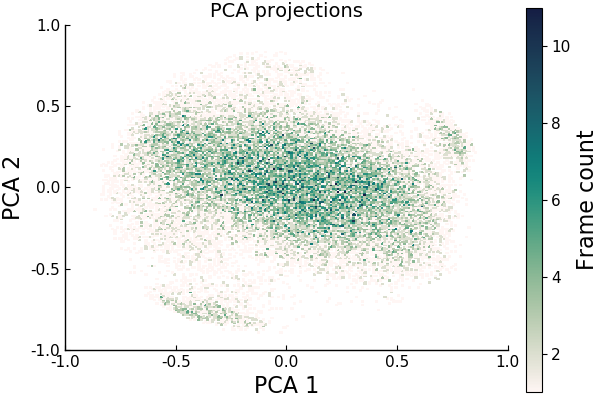

In [82]:
plt_2his = histogram2d(smooth_prj_1_2w9y, smooth_prj_2_2w9y,
    xlims = (-1., 1.), ylims = (-1., 1.),
    guidefont = font(16, "Helvetica"), tickfont = font(11, "Helvetica"),
    yaxis = "PCA 2", xaxis = "PCA 1", title = "PCA projections",
    colorbar_title = "Frame count",
    nbins = 200, seriescolor = :tempo, grid = false)

In [83]:
savefig(plt_2his, joinpath(rtdos, "papel", "2", string("2_PCAHis_", pdb, ".svg")))

marcos_pnu = Array{Int64, 1}(undef, nframes)
marcos_modos = Array{Array{Int64, 1}}(undef, nframes)

for i = 1:nframes
    tmp = reshape(mapslices(x->dot(x, norm_dif[:, i]), modes_2w9y, dims = 1), aa3)
    marcos_pnu[i] = JUMD.get_pnum(tmp)
    marcos_modos[i] = sortperm(abs.(tmp), rev = true)[1:marcos_pnu[i]]
end

# Guardo los pnumbers
fid = h5open(joinpath(rtdos, string("marcos_pnu_", pdb, ".h5")), "w")
write(fid, "pnu", marcos_pnu)
close(fid)

# Guardo los pnumbers modos de c/ frame
fid = h5open(joinpath(rtdos, string("marcos_modos_", pdb, ".h5")), "w")
for i = 1:nframes
    write(fid, string("frame_", i), marcos_modos[i])
end
close(fid)

In [23]:
# Read Pnumbers
marcos_pnu = h5read(joinpath(rtdos, string("marcos_pnu_", pdb, ".h5")), "pnu")

# Read Frecuencia de apariciónd de c/ modo en los subespacios de pnumber modos
marcos_modos = Array{Array{Int64, 1}}(undef, nframes)
fid = h5open(joinpath(rtdos, string("marcos_modos_", pdb, ".h5")), "r")
for i = 1:nframes
    marcos_modos[i] = read(fid, string("frame_", i))
end
close(fid)
flat_marcos_modos = collect(Iterators.flatten(marcos_modos));

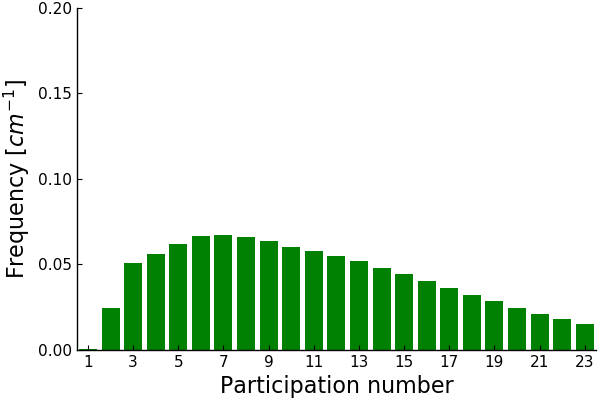

In [97]:
bin_vol = collect(1:1:25)
wgh_vol = fill(1.0, length(marcos_pnu))

# Histograma ponderado
bins_marcos_pnu, his_marcos_pnu = JUMD.WeightedHist(marcos_pnu, bin_vol, wgh_vol, true, false);

plt_his_pn = bar(bins_marcos_pnu .- .5 , his_marcos_pnu,
    ylims = (0, .2), xlims = (.5, 23.5),
    xticks = 1:2:23, yticks = 0:.05:.2,
    guidefont = font(16, "Helvetica"), tickfont = font(11, "Helvetica"),
    fillcolor = Colors.colorant"#008000", linecolor = false,
    yaxis = L"Frequency $[cm^{-1}]$", xaxis = "Participation number",
    legend = false, grid = false)

In [98]:
savefig(plt_his_pn, joinpath(rtdos, "papel",  "2", string("2_HisPn_", pdb, ".svg")))

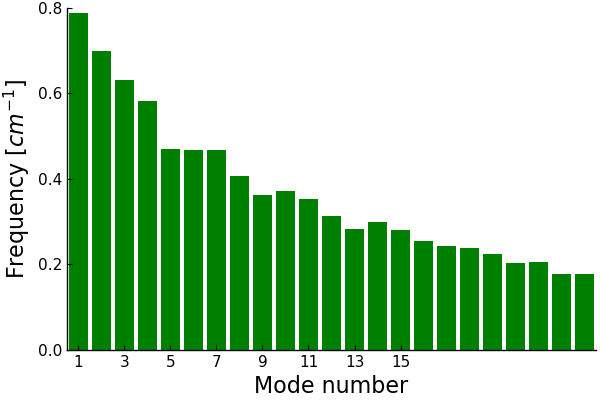

In [95]:
bin_mod = collect(1:1:25)
wgh_mod = fill(1 / nframes, length(flat_marcos_modos))

# Histograma ponderado
bins_marcos_mod, his_marcos_mod = JUMD.WeightedHist(flat_marcos_modos,
    bin_mod, wgh_mod, false, false);

plt_freq_pn = bar(bins_marcos_mod .- .5, his_marcos_mod,
    ylims = (0, .8), xlims = (.5, 23.5),
    xticks = 1:2:15, yticks = 0:.2:.8,
    guidefont = font(16, "Helvetica"), tickfont = font(11, "Helvetica"),
    fillcolor = Colors.colorant"#008000", linecolor = false,
    yaxis = L"Frequency $[cm^{-1}]$", xaxis = "Mode number",
    legend = false, grid = false)

In [96]:
savefig(plt_freq_pn, joinpath(rtdos, "papel",  "2", string("2_ModPn_", pdb, ".svg")))